In [1]:
import os

In [2]:
%pwd

'c:\\Users\\nikhil\\OneDrive\\Desktop\\ML Projects\\Petrol-Price-Forecasting\\research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'c:\\Users\\nikhil\\OneDrive\\Desktop\\ML Projects\\Petrol-Price-Forecasting'

In [5]:
from dataclasses import dataclass
from pathlib import Path

In [6]:
@dataclass
class ModelTrainerConfig:
    root_dir: Path
    data_path: Path
    model_path: Path
    p: int
    d: int
    q: int

In [7]:
from ppf.constants import *
from ppf.utils.common import create_directories, read_yaml

In [8]:
class ConfigurationManager:
    def __init__(self, config_filepath = CONFIG_FILE_PATH, params_filepath = PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)

        create_directories([self.config.artifacts_root])

    def get_model_trainer_config(self) -> ModelTrainerConfig:

        config = self.config.model_trainer
        params = self.params.TrainingArguments

        create_directories([config.root_dir])
        
        model_trainer_config =  ModelTrainerConfig(
            root_dir = config.root_dir,
            data_path = config.data_path,
            model_path = config.model_path,
            p = params.p,
            d = params.d,
            q = params.q
        )
        
        return model_trainer_config

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import pickle
from ppf.logging import logger

class ModelTrainer:
    def __init__(self, config: ModelTrainerConfig):
        self.config = config

    def train(self):
    
        dataset = pd.read_csv(self.config.data_path, index_col=False)  
        dataset.set_index('Date', inplace=True)
        dataset.index = pd.to_datetime(dataset.index)
        # print(dataset.index)

        model=ARIMA(dataset, order=(self.config.p, self.config.d, self.config.q))
        model_fit=model.fit()
        
        # save model
        pickle.dump(model_fit, open(self.config.model_path, 'wb'))
        logger.info(f'Model is stored as {self.config.model_path}')
        
        model = pickle.load(open(self.config.model_path, 'rb'))

        # print(f"file size: {os.path.getsize(self.config.model_path)/1000}KB")
        ts=model.predict(start=150,end=187,dynamic=True)
        dataset.plot(figsize=(10,5))
        ts.plot()

        predictions = model.predict(len(dataset), len(dataset)+15)
        dataset.plot(legend=True, label='Train', figsize=(10,5), title='Predictions')
        predictions.plot(legend=True, label='Prediction')

[2024-05-17 16:53:56,818: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-05-17 16:53:56,824: INFO: common: yaml file: params.yaml loaded successfully]
[2024-05-17 16:53:56,827: INFO: common: directory artifacts created]
[2024-05-17 16:53:56,828: INFO: common: directory artifacts/model_trainer created]


c:\Users\nikhil\.conda\envs\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nikhil\.conda\envs\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nikhil\.conda\envs\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


[2024-05-17 16:53:57,889: INFO: 791814461: Model is stored as artifacts/model_trainer/model.pkl]


c:\Users\nikhil\.conda\envs\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


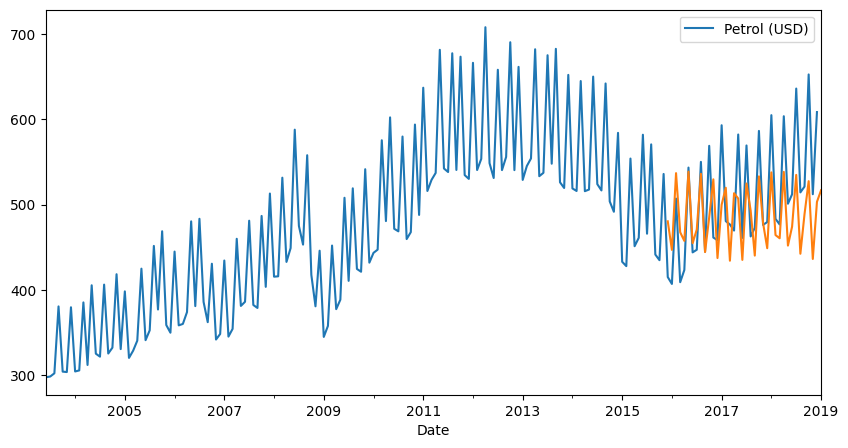

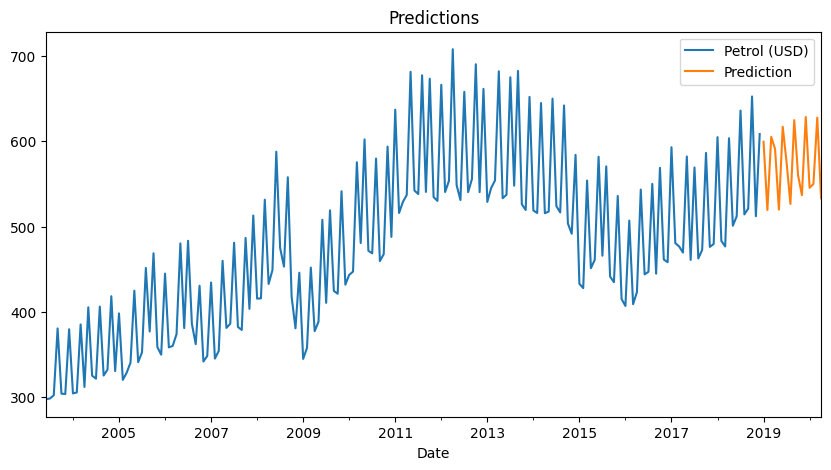

In [19]:
try:
    config = ConfigurationManager()
    model_trainer_config = config.get_model_trainer_config()
    model_trainer_config = ModelTrainer(config = model_trainer_config)
    model_trainer_config.train()
except Exception as e:
    raise e